### 연구 목적: Indoor moving patterns을 이용하여 revisit intention을 예측.

크롤링한 User들의 Wi-fi log을, moving pattern별로 indexing한 후, 적합한 feature들을 선별하여, 어떤 moving pattern이 추후 user revisit과 관련이 있는지 분석하고자 함.

#### Feature description:
특정 moving pattern의 revisit intention을 예측하는 supervised learning(classification) 모델에 이용될 feature들

0. 지금까지 총 방문 횟수
1. User가 찍힌 로그 총 개수: num_logs
2. 한 User가 와이파이에 잡힌 총 시간: total_dwell_time
3. dwell_time > 100인 indoor area 개수: num_sp_100
4. indoor 로그 중 dwell_time > 100인 확률: prob_dwell_100
5. dwell_time > 100인 indoor area에서 보낸 total time: time_sp_100
6. dwell_time > 100인 indoor area들의 variance: std_sp_100


#### Details
1. Moving pattern: 한 유저가 하루동안 매장 안에서 돌아다닌 wi-fi patterns (e.g., out,in,b1,b1-left-1,1f,out,in,b1-left)
2. Raw data의 경우 wi-fi에 찍힌 로그(어떤 device_id가 어떤 장소의 wi-fi 수신기에 몇시부터 몇초간 접속중이었고, 직원인지의 여부와, 현재까지의 revisit count와 가장 최근의 revisit interval)가 하나의 row로 이루어져 있다. 고로, 하나의 moving pattern에 대한 log가 여러 개로 이루어져 있는데, 로그의 날짜와 device_id를 조합하여 key로 삼고 aggregate하여 하나의 moving pattern이 하나의 row로 나타낼 수 있도록 함)
3. 기존 revisit_count 데이터를 보면 꼬인 경우가 많았다, 같은 device_id인데 오늘까지 revisit count가 69였는데 그다음날 7이 된다거나, 그래서 이 데이터를 이용하지 않고 로그를 기반하여 정제해 주었다.
4. revisit_intention은 binary variable이며 우리가 예측하고자 하는 label이다, 매장 방문 이후 n일 이내에 다시 매장 방문 내역이 있다면 revisit_intention = 1 로 표시해 주었다.
5. 매장 방문의 정의: 특정 일에 특정 유저의 moving pattern이 at least 'in을 포함된' 로그를 가지고 있을 경우 매장을 방문하였다고 함. out만 여러번 있는 로그의 경우는 지나가는 행인이라고 생각하여 매장을 방문하지 않았다고 간주.
6. 따라서 어떤 유저가 'in' 로그를 갖는 timestamp가 가장 오래 된 방문을 가장 첫 방문이라고 가정하고, 그 다음 'in' 로그를 갖는 방문을 세서 revisit_count를 계산해 주었다, 이 때 각 방문 사이의 간격은 적어도 1일 이상이다. revisit_count는 각 방문 패턴의 history 정보를 누락시키지 않는다는 목적으로 feature로 삼기로 했다.
7. 참고: User-ID별로 indexing해서 유저별 revisit_count를 naive하게 예측한 이전 모델은 supervised_model(basic_features).ipynb, 에 정리

#### 데이터
1. 781, 786번 매장 데이터 - preprocessing 후 정식으로 매장 내부를 방문한(traj에 in을 포함한 경우) 50381개(0: 46363 vs 1: 4018, revisit_intention 여부)의 moving patterns 중 직원의 moving patterns을 제외한 39043개(0: 37999 vs 1: 1044) 데이터의 revisit intention label 비율을 50:50로 조절한 총 2088개(0: 1044 vs 1: 1044)의 moving patterns을 최종으로 이용함.
2. limitation: 같은 device_id인데 moving pattern별로 직원인 여부가 변하는 경우가 존재했다. 이 moving patterns들을 나중에 제해 주었기 때문에, revisit interval = 120 days을 이용해 계산한 revisit intention 여부가 조금 에러가 있을 수 있음.

####  Preliminary results
<pre>
* 10-fold CV 결과의 평균값
    * Area Under Curve
        * 3 Nearest Neighbors 0.7656
        * AdaBoost            0.8620
        * Naive Bayes         0.8536
        * Decision Tree       0.8636
        * Random Forest       0.8654
    * F1
        * Naive Bayes         0.5718
        * 3 Nearest Neighbors 0.7125
        * Decision Tree       0.7381
        * AdaBoost            0.7533
        * Random Forest       0.7661
        
* XGBOOST 결과
    *    train-auc:     0.8997	 eval-auc:     0.8602
         train-logloss: 0.3817	 eval-logloss: 0.4303
         train-error:   0.2099	 eval-error:   0.2340		
      
    *    test-auc:  0.900915750916
</pre>

### Raw log data manipulation (Index by moving pattern)

In [2]:
### import libraries
import pandas as pd
import datetime
import numpy as np
import re
import plotly.plotly as py
from plotly.tools import FigureFactory as FF

In [4]:
df = pd.read_pickle("../data/786/786.p")
df.head(5)   ### Show raw data

,area,deny,device_id,dwell_time,key,revisit_count,revisit_period,ts
0,out,NaN,78183d8c22014c6b73c100412d43fab0,22,786:7fea91fa7c312d11:out,NaN,NaN,1472642694381
1,out,NaN,59410cf33f8b4f34e60a2dd3a7c96f3a,0,786:7fea91fa7d93fe35:out,1.0,5.0,1472642688704
2,out,NaN,c5ca41ed66022e1b187ac4f5d494bf3d,34,786:7fea91fa7f6f3f61:out,NaN,NaN,1472642681100
3,out,NaN,f4728c4273bcccb372e54973cdd64c3c,41,786:7fea91fa80170ffb:out,NaN,NaN,1472642678415
4,out,NaN,25e062883e35291b488ea1f49200e328,537,786:7fea91fa8168cc81:out,NaN,NaN,1472642673011


In [6]:
df['date'] = df['ts'] // 86400000
# df = df.loc[(df['deny']!= True) & (df['dwell_time'] > 0)]
df = df.loc[(df['dwell_time'] > 0)]
df['date_device_id'] = df.date.map(str) + "_" + df.device_id
df.head(5)

,area,deny,device_id,dwell_time,key,revisit_count,revisit_period,ts,date,date_device_id
0,out,NaN,78183d8c22014c6b73c100412d43fab0,22,786:7fea91fa7c312d11:out,NaN,NaN,1472642694381,17044,17044_78183d8c22014c6b73c100412d43fab0
2,out,NaN,c5ca41ed66022e1b187ac4f5d494bf3d,34,786:7fea91fa7f6f3f61:out,NaN,NaN,1472642681100,17044,17044_c5ca41ed66022e1b187ac4f5d494bf3d
3,out,NaN,f4728c4273bcccb372e54973cdd64c3c,41,786:7fea91fa80170ffb:out,NaN,NaN,1472642678415,17044,17044_f4728c4273bcccb372e54973cdd64c3c
4,out,NaN,25e062883e35291b488ea1f49200e328,537,786:7fea91fa8168cc81:out,NaN,NaN,1472642673011,17044,17044_25e062883e35291b488ea1f49200e328
5,out,True,f53ecbe8f462eb3ab0bfc4eeace04050,1165,786:7fea91fa85b37d76:out,NaN,NaN,1472642655432,17044,17044_f53ecbe8f462eb3ab0bfc4eeace04050


In [5]:
# ### 직원 표시가 한번이라도 있는 device_id 삭제 (dwell_time > 0인 것들 중에서 직원 표시가 있는 id만 삭제. 
# ### dwell_time = 0인 로그가 왜이리 많은지.

# worker = set(df.loc[df['deny']==True]['device_id'].unique().tolist()) ### deny=True가 있는 user id의 set

# df = df[-df.device_id.isin(worker)] ### worker가 아닌 customer들만 df에서 남김.

In [7]:
remainder = (df['ts']%604800000)/1000

def timestamp_to_day(x):
    a = x / 86400
    switcher = {
        0: "Thu",
        1: "Fri",
        2: "Sat",
        3: "Sun",
        4: "Mon",
        5: "Tue",
        6: "Wed"
    }
    return switcher.get(int(a))

df['day'] = remainder.apply(lambda x: timestamp_to_day(x))

df.tail(5) ### show difference after basic preprocessing

,area,deny,device_id,dwell_time,key,revisit_count,revisit_period,ts,date,date_device_id,day
4126394,in,True,3cb3c5d41981dcf7f75ffc1db3378c6e,37975,786:7feb08e1758f3ee2:in,NaN,NaN,1440725116684,16675,16675_3cb3c5d41981dcf7f75ffc1db3378c6e,Fri
4126395,out,True,3cb3c5d41981dcf7f75ffc1db3378c6e,37975,786:7feb08e1758f3ee2:out,NaN,NaN,1440725116684,16675,16675_3cb3c5d41981dcf7f75ffc1db3378c6e,Fri
4126396,1f,NaN,3a256162262ef2f26d547642036db82b,497,786:7feb08e1761b65c6:1f,NaN,NaN,1440725114441,16675,16675_3a256162262ef2f26d547642036db82b,Fri
4126397,in,NaN,3a256162262ef2f26d547642036db82b,497,786:7feb08e1761b65c6:in,NaN,NaN,1440725114441,16675,16675_3a256162262ef2f26d547642036db82b,Fri
4126398,out,NaN,3a256162262ef2f26d547642036db82b,3207,786:7feb08e1761b65c6:out,NaN,NaN,1440725114441,16675,16675_3a256162262ef2f26d547642036db82b,Fri


In [8]:
df['start_hour'] = df['ts'].apply(lambda x: int(datetime.datetime.fromtimestamp(int(x/1000)).strftime('%H')))

In [9]:
df.head(5)

,area,deny,device_id,dwell_time,key,revisit_count,revisit_period,ts,date,date_device_id,day,start_hour
0,out,NaN,78183d8c22014c6b73c100412d43fab0,22,786:7fea91fa7c312d11:out,NaN,NaN,1472642694381,17044,17044_78183d8c22014c6b73c100412d43fab0,Wed,20
2,out,NaN,c5ca41ed66022e1b187ac4f5d494bf3d,34,786:7fea91fa7f6f3f61:out,NaN,NaN,1472642681100,17044,17044_c5ca41ed66022e1b187ac4f5d494bf3d,Wed,20
3,out,NaN,f4728c4273bcccb372e54973cdd64c3c,41,786:7fea91fa80170ffb:out,NaN,NaN,1472642678415,17044,17044_f4728c4273bcccb372e54973cdd64c3c,Wed,20
4,out,NaN,25e062883e35291b488ea1f49200e328,537,786:7fea91fa8168cc81:out,NaN,NaN,1472642673011,17044,17044_25e062883e35291b488ea1f49200e328,Wed,20
5,out,True,f53ecbe8f462eb3ab0bfc4eeace04050,1165,786:7fea91fa85b37d76:out,NaN,NaN,1472642655432,17044,17044_f53ecbe8f462eb3ab0bfc4eeace04050,Wed,20


In [10]:
def feature_generator(df_toy):
    print('Generating features from raw data')
    ### F1: 로그 총 개수
    f1 = df_toy.groupby(['date_device_id'])['ts'].count()
#     print(f1.head(5))

    ### F2: 와이파이에 잡힌 총 시간
    f2 = df_toy.groupby(['date_device_id'])['dwell_time'].sum()
#     print(f2.head(5))

    ### F3: dwell_time > 100인 indoor area 개수
    df_toy_indoor = df_toy.loc[df_toy['area']!='out']
    df_toy_indoor2 = df_toy_indoor.loc[df_toy_indoor['dwell_time']>100]
    f3 = df_toy_indoor2.groupby(['date_device_id'])['area'].count()
#     print(f3.head(5))

    ### F4: indoor 로그 중 dwell_time > 100인 확률
    f3_2 = df_toy_indoor.groupby(['date_device_id'])['area'].count()
    f4 = f3.div(f3_2)
#     print(f4.head(5))

    ### F5: dwell_time > 100인 indoor area에서 보낸 total time
    f5 = df_toy_indoor2.groupby(['date_device_id'])['dwell_time'].sum()
#     print(f5.head(5))

    ### F6: dwell_time > 100인 indoor area들의 standard deviation
    f6 = df_toy_indoor2.groupby(['date_device_id'])['dwell_time'].std()
#     print(f6.head(5))

    ### F7: Day, (Categorical variable)
    f7 = df[['date_device_id', 'day']].drop_duplicates().set_index('date_device_id')

    return f1, f2, f3, f4, f5, f6, f7

In [12]:
def df_generator(df, f1, f2, f3, f4, f5, f6, f7):
    print('Generating a data frame which aggergated features')

#     days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#     days_numlogs = ['num_logs_' + s for s in days]
    columns = ['num_logs', 'total_dwell_time', 'num_sp_100', 'prob_dwell_100', 'time_sp_100', 'std_sp_100', 'day']
#     columns = columns + days_numlogs

    # feature들과의 index의 통일을 위해 np.sort를 이용.
    device_ids = np.sort(df['date_device_id'].unique())       
    df2 = pd.DataFrame(columns=columns, index=device_ids)

    # feature를 df에 삽입
    df2["num_logs"] = f1          
    df2["total_dwell_time"] = f2
    df2["num_sp_100"] = f3
    df2["prob_dwell_100"] = f4
    df2["time_sp_100"] = f5
    df2["std_sp_100"] = f6
    df2["day"] = f7

    
    one_hot = pd.get_dummies(df2['day'])
    df2 = df2.drop('day', axis=1)
    # Join the encoded df
    df2 = df2.join(one_hot)

    return df2

In [13]:
f1, f2, f3, f4, f5, f6, f7 = feature_generator(df)

Generating features from raw data


In [14]:
df2 = df_generator(df, f1, f2, f3, f4, f5, f6, f7)

Generating a data frame which aggergated features


In [15]:
df2.head(5)

,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed
16675_003664d18157446ff4871e69b8d29a5a,1,31,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_0036f0e1a787a0c7f5f17bd9953c2f12,1,4,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_0045b5efaddaf5066f89bdcc8b2e9089,4,1824,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_0049981563153c1bcb65c5c0f3a7aa77,1,120,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_004998978c513f0bfcf598d437d2ce87,1,9,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print(df2.shape)
df2.loc[(df2['num_logs']>10)].head(5)

(1431827, 13)


,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed
16675_028a1f4dbca00ed06814fdda60f1b599,11,7139,7.0,0.700000,3553.0,362.141251,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_09c6ba3f5379a735f3353c377b43244f,24,41023,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_146565f806c971139246842b29adf552,14,10019,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_1bb57295fdd527202a1aeac3e29b9504,40,76788,28.0,0.736842,41251.0,1375.187977,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_342a4950ee5d3de5ce96f27700a01297,56,37246,32.0,0.780488,23980.0,789.190306,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 새로 moving pattern을 인덱싱하는 방법 여기서부터 (160923)

In [17]:
df.groupby(['date_device_id'])['area']

In [18]:
traj = df.groupby(['date_device_id'])['area']
ar = ['out']
temp = traj.unique()
temp2 = temp[-temp.apply(lambda x: (x == ar).all())]

In [19]:
df_sample = df[df.date_device_id.isin(temp2.index.tolist())]

In [20]:
mplogs = df_sample.sort_index(ascending=False).groupby('date_device_id', sort=False).apply(lambda x: x.index.tolist()).sort_index()

In [21]:
mpframe = mplogs.to_frame(name='logs').reset_index()

In [22]:
def finddata(logs, df, data):   # x is a list of logs
   return df.ix[logs][data].tolist()

In [23]:
mpframe['traj'] = mpframe['logs'].apply(lambda x: finddata(x, df, 'area'))

In [24]:
df.head(5)

,area,deny,device_id,dwell_time,key,revisit_count,revisit_period,ts,date,date_device_id,day,start_hour
0,out,NaN,78183d8c22014c6b73c100412d43fab0,22,786:7fea91fa7c312d11:out,NaN,NaN,1472642694381,17044,17044_78183d8c22014c6b73c100412d43fab0,Wed,20
2,out,NaN,c5ca41ed66022e1b187ac4f5d494bf3d,34,786:7fea91fa7f6f3f61:out,NaN,NaN,1472642681100,17044,17044_c5ca41ed66022e1b187ac4f5d494bf3d,Wed,20
3,out,NaN,f4728c4273bcccb372e54973cdd64c3c,41,786:7fea91fa80170ffb:out,NaN,NaN,1472642678415,17044,17044_f4728c4273bcccb372e54973cdd64c3c,Wed,20
4,out,NaN,25e062883e35291b488ea1f49200e328,537,786:7fea91fa8168cc81:out,NaN,NaN,1472642673011,17044,17044_25e062883e35291b488ea1f49200e328,Wed,20
5,out,True,f53ecbe8f462eb3ab0bfc4eeace04050,1165,786:7fea91fa85b37d76:out,NaN,NaN,1472642655432,17044,17044_f53ecbe8f462eb3ab0bfc4eeace04050,Wed,20


In [27]:
mpframe['ts'] = mpframe['logs'].apply(lambda x: finddata(x, df, 'ts'))
mpframe['dwell_time'] = mpframe['logs'].apply(lambda x: finddata(x, df, 'dwell_time'))

In [28]:
mpframe['ts'] = mpframe['ts'].apply(lambda x: [int(y/1000) for y in x])

In [29]:
mpframe.tail(5)

,date_device_id,logs,traj,ts,dwell_time
31558,17044_ecde5f6bdf07b05696820bfbb6bc1576,"[1555, 1552]","[out, in]","[1472636198, 1472636220]","[53, 19]"
31559,17044_f2dcc36d72b41bd74f70135a8ba16fc8,"[3552, 3539, 3538, 3536, 3535, 3520, 3509, 343...","[out, in, 2f, 2f-inner, 2f-left, 1f, 2f-right,...","[1472628224, 1472628289, 1472628290, 147262829...","[815, 709, 673, 404, 331, 634, 102, 267, 69, 150]"
31560,17044_f7d39538aaed1bf22e976aec8892444e,"[973, 972]","[out, in]","[1472638417, 1472638424]","[245, 117]"
31561,17044_fcb5f6456bf3cb590e46526b6527d2d1,"[5943, 5942, 5941, 5940, 5939, 5938]","[out, in, 1f-right, 1f, 1f-left, 1f-inner]","[1472615448, 1472615448, 1472615448, 147261544...","[1379, 274, 183, 274, 273, 183]"
31562,17044_fd0f87ff650bc70919403a9c8eec8aea,"[3977, 3909, 3908, 3900, 3894, 3829, 3578, 357...","[out, in, 1f, 2f, 2f-inner, 2f-left, 1f, 1f-ri...","[1472626183, 1472626504, 1472626504, 147262653...","[2463, 1819, 354, 1593, 1542, 499, 191, 179, 1..."


In [32]:
mpframe['hour_start'] = mpframe['ts'].apply(lambda x: [int(datetime.datetime.fromtimestamp(y).strftime('%H')) for y in x])
mpframe['time_start'] = mpframe['ts'].apply(lambda x: [datetime.datetime.fromtimestamp(y).strftime('%H:%M:%S') for y in x])  # %Y-%m-%d 

In [33]:
mpframe.head(1)

,date_device_id,logs,traj,ts,dwell_time,hour_start,time_start
0,16675_02614c7588f7f8eaa0d3b9047ac08410,"[4121217, 4121026, 4121023, 4121020, 4121003, ...","[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[1440750511, 1440751239, 1440751250, 144075126...","[857, 128, 118, 108, 20, 28, 8]","[17, 17, 17, 17, 17, 17, 17]","[17:28:31, 17:40:39, 17:40:50, 17:41:00, 17:41..."


In [34]:
def calend(x, y):
    return list(map(lambda i, j: i+j, x, y ))

In [35]:
mpframe['ts_end'] = mpframe[['ts', 'dwell_time']].apply(lambda x: calend(*x), axis=1)

In [36]:
mpframe['hour_end'] = mpframe['ts_end'].apply(lambda x: [int(datetime.datetime.fromtimestamp(y).strftime('%H')) for y in x])
mpframe['time_end'] = mpframe['ts_end'].apply(lambda x: [datetime.datetime.fromtimestamp(y).strftime('%H:%M:%S') for y in x])

In [37]:
def printall(mp, i, columnss):
    for column in columnss:
        print(mp[column].ix[i])

In [38]:
printall(mpframe, 714, ['traj', 'ts','ts_end'])

['out', 'in', '2f', '2f-left']
[1441520117, 1441520203, 1441520203, 1441520206]
[1441520318, 1441520279, 1441520209, 1441520208]


In [40]:
def ganttprint(mfs, i):
    
    qa = mfs['traj'].ix[i] + [1000*y for y in mfs['ts'].ix[i]] + [1000*z for z in mfs['ts_end'].ix[i]]
    l = int(len(qa)/3)
    qb = np.asarray(qa)
    shape = ( 3,l )
    qc = qb.reshape( shape ).T
    qd = pd.DataFrame(qc, columns=['Task', 'Start', 'Finish'])
    qd['Start'] = qd['Start'].astype('int') 
    qd['Finish'] = qd['Finish'].astype('int')
    qd['Complete'] = np.arange(40, 60, (60-40)/l)
    qd
    # .as_matrix()

    return qd

In [41]:
mpframe.to_pickle("../data/786/786_mpframe_160923.p")

In [42]:
mpframe = pd.read_pickle("../data/786/786_mpframe_160923.p")

### Gantt chart 가지고 노는 건 160923 gantt charts.ipynb에 더 자세히

In [43]:
lenlogs = np.asarray([len(x) for x in mpframe.logs])
indxx = np.argsort(lenlogs, )
largg = indxx[::-1][:100]

In [44]:
qd = ganttprint(mpframe, largg[85])  ## .sort_index(ascending=False)
print(qd)

fig = FF.create_gantt(qd, colors='Viridis', index_col='Complete', show_colorbar=True)
py.iplot(fig, filename='Numeric Variable', world_readable=True)

        Task          Start         Finish   Complete
0        out  1445041121000  1445042641000  40.000000
1         in  1445041239000  1445041685000  40.338983
2         1f  1445041239000  1445041685000  40.677966
3    1f-left  1445041342000  1445041686000  41.016949
4        out  1445043646000  1445049976000  41.355932
5         in  1445045328000  1445046196000  41.694915
6         1f  1445045328000  1445046196000  42.033898
7    1f-left  1445045329000  1445046076000  42.372881
8   1f-right  1445045848000  1445046109000  42.711864
9         in  1445047456000  1445049975000  43.050847
10   1f-left  1445047456000  1445049975000  43.389831
11        1f  1445047456000  1445049975000  43.728814
12       out  1445051057000  1445054196000  44.067797
13        in  1445051537000  1445054196000  44.406780
14        1f  1445051537000  1445054196000  44.745763
15   1f-left  1445052266000  1445054197000  45.084746
16       out  1445055566000  1445059362000  45.423729
17        in  1445055566000 

### 그냥 각 구역별로 얼마나 오래 커넥트됐는지 feature로 나타냄 (staypoint 생각 ㄴ )

In [46]:
mpframe[['traj','dwell_time']].head(10)

,traj,dwell_time
0,"[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[857, 128, 118, 108, 20, 28, 8]"
1,"[out, in, 3f, 2f, 2f-right, 2f-inner, 2f-left,...","[3548, 1293, 405, 552, 418, 18, 6, 389, 266, 2..."
2,"[out, in, 1f, 1f-inner]","[986, 565, 565, 73]"
3,"[out, in, 3f, in, 1f, out]","[2957, 200, 168, 459, 459, 16]"
4,"[out, in]","[2179, 457]"
5,"[out, in, 1f, 1f-inner, 1f-left]","[1528, 393, 393, 30, 328]"
6,"[out, in, 3f, out]","[15, 3, 3, 185]"
7,"[out, in, 1f, 1f-right, 1f-inner]","[490, 468, 468, 252, 144]"
8,"[out, out, out, out, in, 1f]","[91, 2397, 4323, 5882, 107, 107]"
9,"[out, in, 1f, in, 1f, in, 1f, in, 2f, 2f, 2f-l...","[24386, 502, 502, 391, 391, 66, 66, 4165, 68, ..."


In [52]:
areatypes = df.area.unique().tolist()
areatypes

['out',
 '1f',
 'in',
 '1f-inner',
 '1f-left',
 '1f-right',
 '2f',
 '3f',
 '2f-right',
 '2f-inner',
 '2f-left']

input: n개의 row인데 각각의 row는 두개의 길이가 같은 list - 이 두 리스트를 받아서 각 area별로 머무른 시간 재정렬

In [53]:
def areaStayingAmountFeature(traj, time, areatypes):
#     a = np.zeros(len(areatypes))
    b = np.zeros(len(areatypes))
    for i in range(len(areatypes)):
        for j in range(len(traj)):
            if(areatypes[i] == traj[j]):
                b[i] += time[j]
    v = np.asarray([traj.count(area) for area in areatypes])
    return b

In [55]:
areaStayingAmountFeature(mpframe['traj'].ix[3],mpframe['dwell_time'].ix[3], areatypes)

array([ 2973.,   459.,   659.,     0.,     0.,     0.,     0.,   168.,
           0.,     0.,     0.])

In [64]:
base = np.zeros(len(areatypes))
for i in range(mpframe.shape[0]):
    arr = areaStayingAmountFeature(mpframe['traj'].ix[i],mpframe['dwell_time'].ix[i], areatypes)
    base = np.concatenate((base, arr), axis=0)

In [60]:
mpframe.shape[0]

31563

In [65]:
base.shape

(347204,)

In [66]:
base = base.reshape((mpframe.shape[0]+1, 11))[1:,:]

In [67]:
extft = pd.DataFrame(base, columns=areatypes)

In [68]:
mpframe2 = pd.concat((mpframe, extft), axis=1)

In [69]:
mpframe2

,date_device_id,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,time_end,...,1f,in,1f-inner,1f-left,1f-right,2f,3f,2f-right,2f-inner,2f-left
0,16675_02614c7588f7f8eaa0d3b9047ac08410,"[4121217, 4121026, 4121023, 4121020, 4121003, ...","[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[1440750511, 1440751239, 1440751250, 144075126...","[857, 128, 118, 108, 20, 28, 8]","[17, 17, 17, 17, 17, 17, 17]","[17:28:31, 17:40:39, 17:40:50, 17:41:00, 17:41...","[1440751368, 1440751367, 1440751368, 144075136...","[17, 17, 17, 17, 17, 17, 17]","[17:42:48, 17:42:47, 17:42:48, 17:42:48, 17:42...",...,118.0,128.0,0.0,0.0,108.0,28.0,0.0,8.0,0.0,20.0
1,16675_028a1f4dbca00ed06814fdda60f1b599,"[4126375, 4126196, 4126195, 4126145, 4126140, ...","[out, in, 3f, 2f, 2f-right, 2f-inner, 2f-left,...","[1440725175, 1440726721, 1440726721, 144072701...","[3548, 1293, 405, 552, 418, 18, 6, 389, 266, 2...","[10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]","[10:26:15, 10:52:01, 10:52:01, 10:56:57, 10:57...","[1440728723, 1440728014, 1440727126, 144072756...","[11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11]","[11:25:23, 11:13:34, 10:58:46, 11:06:09, 11:04...",...,389.0,1293.0,14.0,230.0,266.0,552.0,405.0,418.0,18.0,6.0
2,16675_062c73a8b307fd05f6af2472a35671ef,"[4120452, 4120375, 4120373, 4120262]","[out, in, 1f, 1f-inner]","[1440753481, 1440753683, 1440753683, 1440754065]","[986, 565, 565, 73]","[18, 18, 18, 18]","[18:18:01, 18:21:23, 18:21:23, 18:27:45]","[1440754467, 1440754248, 1440754248, 1440754138]","[18, 18, 18, 18]","[18:34:27, 18:30:48, 18:30:48, 18:28:58]",...,565.0,565.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16675_06c041f68ec481883941d47d99d6903f,"[4126346, 4126191, 4126190, 4125983, 4125982, ...","[out, in, 3f, in, 1f, out]","[1440725586, 1440726737, 1440726737, 144072778...","[2957, 200, 168, 459, 459, 16]","[10, 10, 10, 11, 11, 12]","[10:33:06, 10:52:17, 10:52:17, 11:09:40, 11:09...","[1440728543, 1440726937, 1440726905, 144072823...","[11, 10, 10, 11, 11, 12]","[11:22:23, 10:55:37, 10:55:05, 11:17:19, 11:17...",...,459.0,659.0,0.0,0.0,0.0,0.0,168.0,0.0,0.0,0.0
4,16675_0a47ed78e921824cf54dddcf49ae2911,"[4121129, 4120855]","[out, in]","[1440750876, 1440751945]","[2179, 457]","[17, 17]","[17:34:36, 17:52:25]","[1440753055, 1440752402]","[18, 18]","[18:10:55, 18:00:02]",...,0.0,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,16675_1257118518717340418bd1c3fc238246,"[4123475, 4123219, 4123218, 4123214, 4123208]","[out, in, 1f, 1f-inner, 1f-left]","[1440740611, 1440741689, 1440741689, 144074172...","[1528, 393, 393, 30, 328]","[14, 15, 15, 15, 15]","[14:43:31, 15:01:29, 15:01:29, 15:02:00, 15:02...","[1440742139, 1440742082, 1440742082, 144074175...","[15, 15, 15, 15, 15]","[15:08:59, 15:08:02, 15:08:02, 15:02:30, 15:08...",...,393.0,393.0,30.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0
6,16675_14a7904e7069cb6fdc19f04beaa07727,"[4122556, 4122552, 4122551, 4120483]","[out, in, 3f, out]","[1440744996, 1440745007, 1440745007, 1440753394]","[15, 3, 3, 185]","[15, 15, 15, 18]","[15:56:36, 15:56:47, 15:56:47, 18:16:34]","[1440745011, 1440745010, 1440745010, 1440753579]","[15, 15, 15, 18]","[15:56:51, 15:56:50, 15:56:50, 18:19:39]",...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
7,16675_15f34560566d4e2a05557426a36fe4f7,"[4119739, 4119737, 4119736, 4119684, 4119670]","[out, in, 1f, 1f-right, 1f-inner]","[1440755984, 1440755985, 1440755985, 144075620...","[490, 468, 468, 252, 144]","[18, 18, 18, 19, 19]","[18:59:44, 18:59:45, 18:59:45, 19:03:20, 19:04...","[1440756474, 1440756453, 1440756453, 144075645...","[19, 19, 19, 19, 19]","[19:07:54, 19:07:33, 19:07:33, 19:07:32, 19:06...",...,468.0,468.0,144.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0
8,16675_1b74f8c859dfb1d990a695ac8cb3d05a,"[4123053, 4122841, 4121751, 4120193, 4118775, ...","[out, out, out, out, in, 1f]","[1440742633, 1440743822, 1440748394, 144075429...","[91, 2397, 4323, 5882, 107, 107]","[15, 15, 16, 18, 20, 20]","[15:17:13, 15:37:02, 16:53:14, 18:31:32, 20:06...","[1440742724, 1440746219, 1440752717, 144076017...","[15, 16, 18, 

In [70]:
mpframe2['date'] = mpframe2['date_device_id'].apply(lambda x: int(x[:5]))
mpframe2['device_id'] = mpframe2['date_device_id'].apply(lambda x: x[6:])

In [71]:
mpframe2

,date_device_id,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,time_end,...,1f-inner,1f-left,1f-right,2f,3f,2f-right,2f-inner,2f-left,date,device_id
0,16675_02614c7588f7f8eaa0d3b9047ac08410,"[4121217, 4121026, 4121023, 4121020, 4121003, ...","[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[1440750511, 1440751239, 1440751250, 144075126...","[857, 128, 118, 108, 20, 28, 8]","[17, 17, 17, 17, 17, 17, 17]","[17:28:31, 17:40:39, 17:40:50, 17:41:00, 17:41...","[1440751368, 1440751367, 1440751368, 144075136...","[17, 17, 17, 17, 17, 17, 17]","[17:42:48, 17:42:47, 17:42:48, 17:42:48, 17:42...",...,0.0,0.0,108.0,28.0,0.0,8.0,0.0,20.0,16675,02614c7588f7f8eaa0d3b9047ac08410
1,16675_028a1f4dbca00ed06814fdda60f1b599,"[4126375, 4126196, 4126195, 4126145, 4126140, ...","[out, in, 3f, 2f, 2f-right, 2f-inner, 2f-left,...","[1440725175, 1440726721, 1440726721, 144072701...","[3548, 1293, 405, 552, 418, 18, 6, 389, 266, 2...","[10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]","[10:26:15, 10:52:01, 10:52:01, 10:56:57, 10:57...","[1440728723, 1440728014, 1440727126, 144072756...","[11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11]","[11:25:23, 11:13:34, 10:58:46, 11:06:09, 11:04...",...,14.0,230.0,266.0,552.0,405.0,418.0,18.0,6.0,16675,028a1f4dbca00ed06814fdda60f1b599
2,16675_062c73a8b307fd05f6af2472a35671ef,"[4120452, 4120375, 4120373, 4120262]","[out, in, 1f, 1f-inner]","[1440753481, 1440753683, 1440753683, 1440754065]","[986, 565, 565, 73]","[18, 18, 18, 18]","[18:18:01, 18:21:23, 18:21:23, 18:27:45]","[1440754467, 1440754248, 1440754248, 1440754138]","[18, 18, 18, 18]","[18:34:27, 18:30:48, 18:30:48, 18:28:58]",...,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16675,062c73a8b307fd05f6af2472a35671ef
3,16675_06c041f68ec481883941d47d99d6903f,"[4126346, 4126191, 4126190, 4125983, 4125982, ...","[out, in, 3f, in, 1f, out]","[1440725586, 1440726737, 1440726737, 144072778...","[2957, 200, 168, 459, 459, 16]","[10, 10, 10, 11, 11, 12]","[10:33:06, 10:52:17, 10:52:17, 11:09:40, 11:09...","[1440728543, 1440726937, 1440726905, 144072823...","[11, 10, 10, 11, 11, 12]","[11:22:23, 10:55:37, 10:55:05, 11:17:19, 11:17...",...,0.0,0.0,0.0,0.0,168.0,0.0,0.0,0.0,16675,06c041f68ec481883941d47d99d6903f
4,16675_0a47ed78e921824cf54dddcf49ae2911,"[4121129, 4120855]","[out, in]","[1440750876, 1440751945]","[2179, 457]","[17, 17]","[17:34:36, 17:52:25]","[1440753055, 1440752402]","[18, 18]","[18:10:55, 18:00:02]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16675,0a47ed78e921824cf54dddcf49ae2911
5,16675_1257118518717340418bd1c3fc238246,"[4123475, 4123219, 4123218, 4123214, 4123208]","[out, in, 1f, 1f-inner, 1f-left]","[1440740611, 1440741689, 1440741689, 144074172...","[1528, 393, 393, 30, 328]","[14, 15, 15, 15, 15]","[14:43:31, 15:01:29, 15:01:29, 15:02:00, 15:02...","[1440742139, 1440742082, 1440742082, 144074175...","[15, 15, 15, 15, 15]","[15:08:59, 15:08:02, 15:08:02, 15:02:30, 15:08...",...,30.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0,16675,1257118518717340418bd1c3fc238246
6,16675_14a7904e7069cb6fdc19f04beaa07727,"[4122556, 4122552, 4122551, 4120483]","[out, in, 3f, out]","[1440744996, 1440745007, 1440745007, 1440753394]","[15, 3, 3, 185]","[15, 15, 15, 18]","[15:56:36, 15:56:47, 15:56:47, 18:16:34]","[1440745011, 1440745010, 1440745010, 1440753579]","[15, 15, 15, 18]","[15:56:51, 15:56:50, 15:56:50, 18:19:39]",...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,16675,14a7904e7069cb6fdc19f04beaa07727
7,16675_15f34560566d4e2a05557426a36fe4f7,"[4119739, 4119737, 4119736, 4119684, 4119670]","[out, in, 1f, 1f-right, 1f-inner]","[1440755984, 1440755985, 1440755985, 144075620...","[490, 468, 468, 252, 144]","[18, 18, 18, 19, 19]","[18:59:44, 18:59:45, 18:59:45, 19:03:20, 19:04...","[1440756474, 1440756453, 1440756453, 144075645...","[19, 19, 19, 19, 19]","[19:07:54, 19:07:33, 19:07:33, 19:07:32, 19:06...",...,144.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,16675,15f34560566d4e2a05557426a36fe4f7
8,16675_1b74f8c859dfb1d990a695ac8cb3d05a,"[4123053, 4122841, 4121751, 4120193, 4118775, ...","[out, out, out, out, in, 1f]","[

In [72]:
### Count visit_counts for each user (history)

mpframe2.loc[:,'cnt'] = 1
mpframe2['new_visit_count'] = mpframe2[['device_id', 'cnt']].groupby('device_id').cumsum()

In [73]:
# trajs = trajs_full.loc[trajs_full.new_visit_count<=3]
mpframe2.loc[:, 'revisit_intention'] = 0
revisit_interval_thres = 90

for ids in mpframe2['device_id'].unique():
    dff = mpframe2.loc[mpframe2['device_id']==ids]   
    a = 0
    date = 16672
    prev_idx = ''
    for index, row in dff.iterrows():
        if a+1 == row['new_visit_count']:
            if date+revisit_interval_thres > row['date']:
#                 print('regular revisit: {0} days interval'.format(row['date']-date))
#                 print('previous index: ',prev_idx)
                mpframe2.set_value(prev_idx, 'revisit_intention', 1)
                ## 이때만 하기.
                
#             elif row['new_visit_count'] == 1:
#                 print('regular revisit: {0} days interval'.format(row['date']-date))
                
#             else:
#                 print('Irregular revisit: {0} days interval'.format(row['date']-date))

            prev_idx = index
                
#             print(row,'\n')
            a = row['new_visit_count']
            date = row['date']

In [86]:
mpframe2.to_pickle("../data/786/786_mpframe2.p")
mpframe2 = pd.read_pickle("../data/786/786_mpframe2.p")

In [90]:
mpframe2[mpframe2.columns[1:]]

,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,time_end,out,...,2f,3f,2f-right,2f-inner,2f-left,date,device_id,cnt,new_visit_count,revisit_intention
0,"[4121217, 4121026, 4121023, 4121020, 4121003, ...","[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[1440750511, 1440751239, 1440751250, 144075126...","[857, 128, 118, 108, 20, 28, 8]","[17, 17, 17, 17, 17, 17, 17]","[17:28:31, 17:40:39, 17:40:50, 17:41:00, 17:41...","[1440751368, 1440751367, 1440751368, 144075136...","[17, 17, 17, 17, 17, 17, 17]","[17:42:48, 17:42:47, 17:42:48, 17:42:48, 17:42...",857.0,...,28.0,0.0,8.0,0.0,20.0,16675.0,02614c7588f7f8eaa0d3b9047ac08410,1.0,1.0,0.0
1,"[4126375, 4126196, 4126195, 4126145, 4126140, ...","[out, in, 3f, 2f, 2f-right, 2f-inner, 2f-left,...","[1440725175, 1440726721, 1440726721, 144072701...","[3548, 1293, 405, 552, 418, 18, 6, 389, 266, 2...","[10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]","[10:26:15, 10:52:01, 10:52:01, 10:56:57, 10:57...","[1440728723, 1440728014, 1440727126, 144072756...","[11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11]","[11:25:23, 11:13:34, 10:58:46, 11:06:09, 11:04...",3548.0,...,552.0,405.0,418.0,18.0,6.0,16675.0,028a1f4dbca00ed06814fdda60f1b599,1.0,1.0,0.0
2,"[4120452, 4120375, 4120373, 4120262]","[out, in, 1f, 1f-inner]","[1440753481, 1440753683, 1440753683, 1440754065]","[986, 565, 565, 73]","[18, 18, 18, 18]","[18:18:01, 18:21:23, 18:21:23, 18:27:45]","[1440754467, 1440754248, 1440754248, 1440754138]","[18, 18, 18, 18]","[18:34:27, 18:30:48, 18:30:48, 18:28:58]",986.0,...,0.0,0.0,0.0,0.0,0.0,16675.0,062c73a8b307fd05f6af2472a35671ef,1.0,1.0,0.0
3,"[4126346, 4126191, 4126190, 4125983, 4125982, ...","[out, in, 3f, in, 1f, out]","[1440725586, 1440726737, 1440726737, 144072778...","[2957, 200, 168, 459, 459, 16]","[10, 10, 10, 11, 11, 12]","[10:33:06, 10:52:17, 10:52:17, 11:09:40, 11:09...","[1440728543, 1440726937, 1440726905, 144072823...","[11, 10, 10, 11, 11, 12]","[11:22:23, 10:55:37, 10:55:05, 11:17:19, 11:17...",2973.0,...,0.0,168.0,0.0,0.0,0.0,16675.0,06c041f68ec481883941d47d99d6903f,1.0,1.0,0.0
4,"[4121129, 4120855]","[out, in]","[1440750876, 1440751945]","[2179, 457]","[17, 17]","[17:34:36, 17:52:25]","[1440753055, 1440752402]","[18, 18]","[18:10:55, 18:00:02]",2179.0,...,0.0,0.0,0.0,0.0,0.0,16675.0,0a47ed78e921824cf54dddcf49ae2911,1.0,1.0,1.0
5,"[4123475, 4123219, 4123218, 4123214, 4123208]","[out, in, 1f, 1f-inner, 1f-left]","[1440740611, 1440741689, 1440741689, 144074172...","[1528, 393, 393, 30, 328]","[14, 15, 15, 15, 15]","[14:43:31, 15:01:29, 15:01:29, 15:02:00, 15:02...","[1440742139, 1440742082, 1440742082, 144074175...","[15, 15, 15, 15, 15]","[15:08:59, 15:08:02, 15:08:02, 15:02:30, 15:08...",1528.0,...,0.0,0.0,0.0,0.0,0.0,16675.0,1257118518717340418bd1c3fc238246,1.0,1.0,0.0
6,"[4122556, 4122552, 4122551, 4120483]","[out, in, 3f, out]","[1440744996, 1440745007, 1440745007, 1440753394]","[15, 3, 3, 185]","[15, 15, 15, 18]","[15:56:36, 15:56:47, 15:56:47, 18:16:34]","[1440745011, 1440745010, 1440745010, 1440753579]","[15, 15, 15, 18]","[15:56:51, 15:56:50, 15:56:50, 18:19:39]",200.0,...,0.0,3.0,0.0,0.0,0.0,16675.0,14a7904e7069cb6fdc19f04beaa07727,1.0,1.0,1.0
7,"[4119739, 4119737, 4119736, 4119684, 4119670]","[out, in, 1f, 1f-right, 1f-inner]","[1440755984, 1440755985, 1440755985, 144075620...","[490, 468, 468, 252, 144]","[18, 18, 18, 19, 19]","[18:59:44, 18:59:45, 18:59:45, 19:03:20, 19:04...","[1440756474, 1440756453, 1440756453, 144075645...","[19, 19, 19, 19, 19]","[19:07:54, 19:07:33, 19:07:33, 19:07:32, 19:06...",490.0,...,0.0,0.0,0.0,0.0,0.0,16675.0,15f34560566d4e2a05557426a36fe4f7,1.0,1.0,0.0
8,"[4123053, 4122841, 4121751, 4120193, 4118775, ...","[out, out, out, out, in, 1f]","[1440742633, 1440743822, 1440748394, 144075429...","[91, 2397, 4323, 5882, 107, 107]","[15, 15, 16, 18, 20, 20]","[15:17:13, 15:37:02, 16:53:14, 18:31:32, 20:06...","[1440742724, 1440746219, 1440752717, 144076017...","[15, 16, 18, 20, 20, 20]","[15:18:44, 16:16:59, 18:05:17, 20:09:34, 20:07...",12

In [100]:
cols = mpframe2.columns.tolist()
newcols = cols[:9]+cols[22:23]+cols[21:22]+cols[10:11]+cols[12:13]+cols[11:12]+cols[13:21]+cols[24:]
newcols = newcols[:18]+newcols[20:22]+newcols[19:20]+newcols[18:19]+newcols[22:]
mpframe2 = mpframe2[newcols]

In [102]:
mpframe2.to_pickle("../data/786/786_mpframe2.p")
del mpframe
del mpframe2

In [103]:
mpframe2 = pd.read_pickle("../data/786/786_mpframe2.p")

1.0      16688
2.0       2178
3.0        609
4.0        254
5.0        122
6.0         71
7.0         39
8.0         28
9.0         28
10.0        16
11.0        13
12.0         8
13.0         8
14.0         5
15.0         5
16.0         2
17.0         5
18.0         1
19.0         1
20.0         2
21.0         2
22.0         3
23.0         3
24.0         2
27.0         1
28.0         3
29.0         1
32.0         1
40.0         1
50.0         1
57.0         1
59.0         1
63.0         1
74.0         1
90.0         1
91.0         1
100.0        1
106.0        1
107.0        1
111.0        1
126.0        1
127.0        1
158.0        1
178.0        1
203.0        1
227.0        3
277.0        1
282.0        1
284.0        1
300.0        1
356.0        1
365.0        1
367.0        1
Name: new_visit_count, dtype: int64


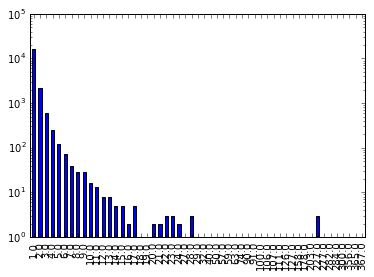

In [107]:
## 제대로 된 로그가 거의 없음 (재방문 >= 1 인 로그가 1,876,809개 중 50,233개밖에 안됨.) <- deny=1 삭제 안했던 이전 결과

## deny 삭제하고 난 결과 - 이렇게 ~이상 프린트찍은 결과를 분석할 때는 조심! 1번 방문한 사람수는 23611명이 아니다! 
# print(trajs_full.shape)
# print(trajs_full.loc[trajs_full.new_visit_count>=1].shape)
# print(trajs_full.loc[trajs_full.new_visit_count>=2].shape)
# print(trajs_full.loc[trajs_full.new_visit_count>=21].shape)  

# 재방문 횟수별 사람 수
customer_revisit_count = mpframe2.groupby(['device_id'])['new_visit_count'].max().value_counts().sort_index()
print (customer_revisit_count)

%matplotlib inline 
customer_revisit_count.plot(kind='bar', logy=True)

In [124]:
mpframe2 = mpframe2.set_index('date_device_id')

In [125]:
trajs_combined = pd.concat([mpframe2, df2], axis=1, join='inner')

In [130]:
columns = ['logs', 'traj', 'ts', 'dwell_time', 'hour_start', 'time_start',
       'ts_end', 'hour_end', 'device_id', 'date', 'out', 'in', '1f',
       '1f-inner', '1f-left', '1f-right', '2f', '2f-inner', '2f-left',
       '2f-right', '3f', 'num_logs','total_dwell_time', 'num_sp_100', 'prob_dwell_100', 'time_sp_100',
       'std_sp_100', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'new_visit_count', 'revisit_intention', ]

In [131]:
trajs_combined = trajs_combined[columns]

In [149]:
### 어떤 moving patterns들이 있나 확인 (revisit_intention == 1인 경우)
print('Top 10 trajectories with revisit intention in 3 months\n', trajs_combined.loc[trajs_combined['revisit_intention'] == 1]['traj'].apply(lambda x: ','.join(str(e) for e in x)).value_counts().head(10))
print(' ')
print('Top 10 trajectories with no revisit intention in 3 months\n', trajs_combined.loc[trajs_combined['revisit_intention'] == 0]['traj'].apply(lambda x: ','.join(str(e) for e in x)).value_counts().head(10))



Top 10 trajectories with revisit intention in 3 months
 out,in,1f             627
out,in                399
out,in,1f,out         183
out,out,in,1f         170
out,in,2f             158
out,in,1f,1f-right    146
out,in,out            103
out,out,in             89
out,in,1f-right,1f     87
out,in,3f              76
Name: traj, dtype: int64
 
Top 10 trajectories with no revisit intention in 3 months
 out,in,1f             3320
out,in                2395
out,in,2f              824
out,in,1f,out          747
out,in,1f,1f-right     656
out,out,in,1f          630
out,in,out             516
out,out,in             485
out,in,1f-right,1f     310
out,in,1f,1f-inner     294
Name: traj, dtype: int64


In [150]:
trajs_combined.head(5)

,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,device_id,date,...,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,new_visit_count,revisit_intention
16675_02614c7588f7f8eaa0d3b9047ac08410,"[4121217, 4121026, 4121023, 4121020, 4121003, ...","[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[1440750511, 1440751239, 1440751250, 144075126...","[857, 128, 118, 108, 20, 28, 8]","[17, 17, 17, 17, 17, 17, 17]","[17:28:31, 17:40:39, 17:40:50, 17:41:00, 17:41...","[1440751368, 1440751367, 1440751368, 144075136...","[17, 17, 17, 17, 17, 17, 17]",02614c7588f7f8eaa0d3b9047ac08410,16675.0,...,10.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_028a1f4dbca00ed06814fdda60f1b599,"[4126375, 4126196, 4126195, 4126145, 4126140, ...","[out, in, 3f, 2f, 2f-right, 2f-inner, 2f-left,...","[1440725175, 1440726721, 1440726721, 144072701...","[3548, 1293, 405, 552, 418, 18, 6, 389, 266, 2...","[10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]","[10:26:15, 10:52:01, 10:52:01, 10:56:57, 10:57...","[1440728723, 1440728014, 1440727126, 144072756...","[11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11]",028a1f4dbca00ed06814fdda60f1b599,16675.0,...,362.141251,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_062c73a8b307fd05f6af2472a35671ef,"[4120452, 4120375, 4120373, 4120262]","[out, in, 1f, 1f-inner]","[1440753481, 1440753683, 1440753683, 1440754065]","[986, 565, 565, 73]","[18, 18, 18, 18]","[18:18:01, 18:21:23, 18:21:23, 18:27:45]","[1440754467, 1440754248, 1440754248, 1440754138]","[18, 18, 18, 18]",062c73a8b307fd05f6af2472a35671ef,16675.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_06c041f68ec481883941d47d99d6903f,"[4126346, 4126191, 4126190, 4125983, 4125982, ...","[out, in, 3f, in, 1f, out]","[1440725586, 1440726737, 1440726737, 144072778...","[2957, 200, 168, 459, 459, 16]","[10, 10, 10, 11, 11, 12]","[10:33:06, 10:52:17, 10:52:17, 11:09:40, 11:09...","[1440728543, 1440726937, 1440726905, 144072823...","[11, 10, 10, 11, 11, 12]",06c041f68ec481883941d47d99d6903f,16675.0,...,159.307878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_0a47ed78e921824cf54dddcf49ae2911,"[4121129, 4120855]","[out, in]","[1440750876, 1440751945]","[2179, 457]","[17, 17]","[17:34:36, 17:52:25]","[1440753055, 1440752402]","[18, 18]",0a47ed78e921824cf54dddcf49ae2911,16675.0,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [151]:
trajs_combined.head(5)

,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,device_id,date,...,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,new_visit_count,revisit_intention
16675_02614c7588f7f8eaa0d3b9047ac08410,"[4121217, 4121026, 4121023, 4121020, 4121003, ...","[out, in, 1f, 1f-right, 2f-left, 2f, 2f-right]","[1440750511, 1440751239, 1440751250, 144075126...","[857, 128, 118, 108, 20, 28, 8]","[17, 17, 17, 17, 17, 17, 17]","[17:28:31, 17:40:39, 17:40:50, 17:41:00, 17:41...","[1440751368, 1440751367, 1440751368, 144075136...","[17, 17, 17, 17, 17, 17, 17]",02614c7588f7f8eaa0d3b9047ac08410,16675.0,...,10.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_028a1f4dbca00ed06814fdda60f1b599,"[4126375, 4126196, 4126195, 4126145, 4126140, ...","[out, in, 3f, 2f, 2f-right, 2f-inner, 2f-left,...","[1440725175, 1440726721, 1440726721, 144072701...","[3548, 1293, 405, 552, 418, 18, 6, 389, 266, 2...","[10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]","[10:26:15, 10:52:01, 10:52:01, 10:56:57, 10:57...","[1440728723, 1440728014, 1440727126, 144072756...","[11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11]",028a1f4dbca00ed06814fdda60f1b599,16675.0,...,362.141251,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_062c73a8b307fd05f6af2472a35671ef,"[4120452, 4120375, 4120373, 4120262]","[out, in, 1f, 1f-inner]","[1440753481, 1440753683, 1440753683, 1440754065]","[986, 565, 565, 73]","[18, 18, 18, 18]","[18:18:01, 18:21:23, 18:21:23, 18:27:45]","[1440754467, 1440754248, 1440754248, 1440754138]","[18, 18, 18, 18]",062c73a8b307fd05f6af2472a35671ef,16675.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_06c041f68ec481883941d47d99d6903f,"[4126346, 4126191, 4126190, 4125983, 4125982, ...","[out, in, 3f, in, 1f, out]","[1440725586, 1440726737, 1440726737, 144072778...","[2957, 200, 168, 459, 459, 16]","[10, 10, 10, 11, 11, 12]","[10:33:06, 10:52:17, 10:52:17, 11:09:40, 11:09...","[1440728543, 1440726937, 1440726905, 144072823...","[11, 10, 10, 11, 11, 12]",06c041f68ec481883941d47d99d6903f,16675.0,...,159.307878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16675_0a47ed78e921824cf54dddcf49ae2911,"[4121129, 4120855]","[out, in]","[1440750876, 1440751945]","[2179, 457]","[17, 17]","[17:34:36, 17:52:25]","[1440753055, 1440752402]","[18, 18]",0a47ed78e921824cf54dddcf49ae2911,16675.0,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [152]:
trajs_combined.to_pickle("../data/786/786_trajs_combined.p")
del trajs_combined

### Final data preprocessing
직원 로그 제거, 라벨 비율 맞추기

In [3]:
trajs_combined = pd.read_pickle("../data/786/786_trajs_combined.p")

In [10]:
trajs_combined.columns

Index(['logs', 'traj', 'ts', 'dwell_time', 'hour_start', 'time_start',
       'ts_end', 'hour_end', 'device_id', 'date', 'out', 'in', '1f',
       '1f-inner', '1f-left', '1f-right', '2f', '2f-inner', '2f-left',
       '2f-right', '3f', 'num_logs', 'total_dwell_time', 'num_sp_100',
       'prob_dwell_100', 'time_sp_100', 'std_sp_100', 'Fri', 'Mon', 'Sat',
       'Sun', 'Thu', 'Tue', 'Wed', 'new_visit_count', 'revisit_intention'],
      dtype='object')

In [137]:
trajs_combined.shape

(31563, 36)

In [63]:
trajs_combined.tail(1)

,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,device_id,date,...,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,new_visit_count,revisit_intention
17044_fd0f87ff650bc70919403a9c8eec8aea,"[3977, 3909, 3908, 3900, 3894, 3829, 3578, 357...","[out, in, 1f, 2f, 2f-inner, 2f-left, 1f, 1f-ri...","[1472626183, 1472626504, 1472626504, 147262653...","[2463, 1819, 354, 1593, 1542, 499, 191, 179, 1...","[15, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17]","[15:49:43, 15:55:04, 15:55:04, 15:55:38, 15:55...","[1472628646, 1472628323, 1472626858, 147262813...","[16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17]",fd0f87ff650bc70919403a9c8eec8aea,17044.0,...,732.148859,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0


In [77]:
### trajs_combined.date이 16955 이후면서 revisit intention이 0인 개수 체크: 4427개
### 최근 3달 내 데이터 중 revisit intention이 없는 경우는 제거 = 실제로 추후에 방문이 있었는지는 모름. 
recent3monthvisitors = trajs_combined.loc[(trajs_combined.date > 16955) & (trajs_combined.revisit_intention == 0)].index
print(recent3monthvisitors.shape)

(4427,)


In [114]:
trajs_excludelast3months = trajs_combined.drop(recent3monthvisitors)
print(trajs_excludelast3months.shape)

(27136, 36)


In [107]:
visitcounts = trajs_excludelast3months.groupby(['device_id'])['new_visit_count'].max()

In [108]:
freqvisitors = visitcounts.loc[visitcounts > 10].keys()

In [115]:
### 그 중 10번 이상 온 사람들은 제거.

# trajs_combined.loc[trajs_combined.device_id == '018988ce7ac54fa02ef37c62bcca54a9']
trajs_freqremoved = trajs_excludelast3months.loc[-trajs_excludelast3months.device_id.isin(freqvisitors.tolist())]
# trajs_freqremoved = trajs_excludelast3months.drop(freqvisitors)
trajs_freqremoved.shape

(21552, 36)

1.0     14145
2.0      1756
3.0       502
4.0       209
5.0        89
6.0        56
7.0        35
8.0        27
9.0        19
10.0       14
Name: new_visit_count, dtype: int64


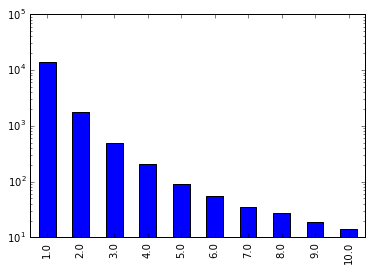

In [122]:
customer_revisit_count2 = trajs_freqremoved.groupby(['device_id'])['new_visit_count'].max().value_counts().sort_index()
print (customer_revisit_count2)

%matplotlib inline 
customer_revisit_count2.plot(kind='bar', logy=True)

In [127]:
### revisit_intention이 없는 무빙 패턴 중 랜덤하게 5개 display
trajs_combined.iloc[np.random.permutation(len(trajs_combined))].loc[trajs_combined['revisit_intention']==0].head(5)

,logs,traj,ts,dwell_time,hour_start,time_start,ts_end,hour_end,device_id,date,...,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,new_visit_count,revisit_intention
16945_33039ef970de0a0e9a7fb06accba99b5,"[1099715, 1099023, 1099022, 1099021, 1099020]","[out, out, in, 1f, 1f-inner]","[1464055758, 1464059903, 1464059903, 146405990...","[7, 77, 73, 73, 73]","[11, 12, 12, 12, 12]","[11:09:18, 12:18:23, 12:18:23, 12:18:23, 12:18...","[1464055765, 1464059980, 1464059976, 146405997...","[11, 12, 12, 12, 12]",33039ef970de0a0e9a7fb06accba99b5,16945.0,...,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0
16938_b957c0a06aca3714714c33cfd0d95f99,"[1179208, 1178861]","[out, in]","[1463470233, 1463471516]","[3774, 51]","[16, 16]","[16:30:33, 16:51:56]","[1463474007, 1463471567]","[17, 16]",b957c0a06aca3714714c33cfd0d95f99,16938.0,...,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
16856_9480f46170b6a374dec6d9da80deb431,"[2136451, 2136255]","[out, in]","[1456377977, 1456378809]","[1688, 589]","[14, 14]","[14:26:17, 14:40:09]","[1456379665, 1456379398]","[14, 14]",9480f46170b6a374dec6d9da80deb431,16856.0,...,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
16818_70d3275823c4ec71c57190d25dbf35ff,"[2562646, 2562638, 2562637, 2558668]","[out, in, 1f, out]","[1453086444, 1453086461, 1453086461, 1453104296]","[49, 17, 17, 38]","[12, 12, 12, 17]","[12:07:24, 12:07:41, 12:07:41, 17:04:56]","[1453086493, 1453086478, 1453086478, 1453104334]","[12, 12, 12, 17]",70d3275823c4ec71c57190d25dbf35ff,16818.0,...,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16970_b4c673f2faa1ac65963a6de2c87b7243,"[802158, 802157, 802156, 801834, 801760]","[out, in, 2f, 1f, 1f-right]","[1466240000, 1466240000, 1466240000, 146624120...","[1508, 1434, 891, 228, 11]","[17, 17, 17, 18, 18]","[17:53:20, 17:53:20, 17:53:20, 18:13:26, 18:17...","[1466241508, 1466241434, 1466240891, 146624143...","[18, 18, 18, 18, 18]",b4c673f2faa1ac65963a6de2c87b7243,16970.0,...,603.994205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [128]:
## Revisit intention 비율을 50대 50으로 맞춤 (sampling)
# trajs_combined = trajs_combined.loc[trajs_combined['prob_deny']==0]
trajs_1 = trajs_freqremoved.loc[trajs_freqremoved['revisit_intention']==1]
trajs_0 = trajs_freqremoved.loc[trajs_freqremoved['revisit_intention']==0]

new_trajs_0 = trajs_0.iloc[np.random.permutation(len(trajs_0))][:trajs_1.shape[0]]  ## trajs_1의 크기에 맞게 trajs_0을 랜덤 샘플링.

# 1:1 비율의 dataframe 만들기
trajs_combined_balanced = pd.concat([trajs_1, new_trajs_0])
trajs_combined_balanced = trajs_combined_balanced.sample(frac=1)  ## reshuffle after concatenation

In [130]:
# trajs_combined_balanced['traj'].apply(lambda x: str(x)).value_counts()

In [141]:
print(trajs_combined_balanced.shape)

(8886, 36)


### XGBoost로 테스트 

In [9]:
import datetime
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import random
import zipfile
import time
import shutil
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import json
import re

trajs_combined = pd.read_pickle("../data/786/786_trajs_combined.p")
random.seed(2016)
datadir = "../data/786/786.p"

In [10]:
def run_xgb(train, test, features, target, random_state=0):
    start_time = time.time()
    objective = "reg:logistic"
    booster = "gbtree"
    eval_metric = ["auc", "logloss", "error"]
    eta = 0.1
    max_depth = 3
    subsample = 0.7
    colsample_bytree = 0.7
    silent = 1

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": objective,
#         "num_class": 2,
        "booster" : booster,
        "eval_metric": eval_metric,
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": silent,
        "seed": random_state,
    }
    num_boost_round = 1000
    early_stopping_rounds = 100
    test_size = 0.1

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index))
    print('Length valid:', len(X_valid.index))
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)

#     res = xgb.cv(params, dtrain, num_boost_round, nfold=10)
#     print(res)
#     print('running cross validation, disable standard deviation display')
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration)

    

    print("Predict test set...")
    test_prediction = gbm.predict(xgb.DMatrix(test[features]), ntree_limit=gbm.best_iteration)

    training_time = round((time.time() - start_time)/60, 2)
    print('Training time: {} minutes'.format(training_time))

    print(gbm)
    
#     score = f1_score(test[target], test_prediction.tolist())
    score = roc_auc_score(test[target], test_prediction.tolist())
    
#     print('f1 score: ', score)
    print('roc_auc_score: ', score)

    # To save logs
    explog = {}
    explog['features'] = features
    explog['target'] = target
    explog['params'] = {}
    explog['params']['objective'] = objective
    explog['params']['booster'] = booster
    explog['params']['eval_metric'] = eval_metric
    explog['params']['eta'] = eta
    explog['params']['max_depth'] = max_depth
    explog['params']['subsample'] = subsample
    explog['params']['colsample_bytree'] = colsample_bytree
    explog['params']['silent'] = silent
    explog['params']['seed'] = random_state
    explog['params']['num_boost_round'] = num_boost_round
    explog['params']['early_stopping_rounds'] = early_stopping_rounds
    explog['params']['test_size'] = test_size
    explog['length_train']= len(X_train.index)
    explog['length_valid']= len(X_valid.index)
    # explog['gbm_best_iteration']= 
    explog['score'] = score
    explog['training_time'] = training_time

    return test_prediction.tolist(), score, explog, gbm

In [11]:
def updateLog(explog, logPath):
    try:
        with open(logPath, 'r') as f:
            obob = json.load(f)
        f.close()
    except:
        obob = []


    obob.append(explog)

    with open(logPath, 'w') as f:
        json.dump(obob, f)
    f.close()

In [132]:
df_learning = trajs_combined_balanced
df_learning = df_learning.fillna(0)
df_learning = df_learning.reindex(np.random.permutation(df_learning.index))

In [13]:
df_learning = df_learning.fillna(0)
df_learning = df_learning.reindex(np.random.permutation(df_learning.index))

idx = int(len(df_learning.index)*9/10)
train = df_learning[:idx]
test = df_learning[idx:]
features = list(df_learning.columns)[3:-1]
target = 'revisit_intention'

print('Length of train: ', len(train))
print('Length of test: ', len(test))
print('Features [{}]: {}'.format(len(features), sorted(features)))

test_prediction, score, explog, gbm = run_xgb(train, test, features, target)
print('Score: ', score)

logPath = '../result/results.json'

explog['dataset']= datadir
explog['ts']= time.strftime('%Y-%m-%d %H:%M:%S')

updateLog(explog, logPath)

Length of train:  4840
Length of test:  538
Features [14]: ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'new_visit_count', 'num_logs', 'num_sp_100', 'prob_dwell_100', 'std_sp_100', 'time_sp_100', 'total_dwell_time']
XGBoost params. ETA: 0.1, MAX_DEPTH: 3, SUBSAMPLE: 0.7, COLSAMPLE_BY_TREE: 0.7
Length train: 4356
Length valid: 484
[0]	train-auc:0.66569	train-logloss:0.683752	train-error:0.362259	eval-auc:0.622806	eval-logloss:0.686247	eval-error:0.419421
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 100 rounds.
[1]	train-auc:0.681767	train-logloss:0.679973	train-error:0.362259	eval-auc:0.633256	eval-logloss:0.684518	eval-error:0.419421
[2]	train-auc:0.685059	train-logloss:0.673131	train-error:0.362489	eval-auc:0.634656	eval-logloss:0.679183	eval-error:0.415289
[3]	train-auc:0.68469	train-logloss:0.670758	train-error:0.360652	eval-auc:0.62891	eval-logloss:0.678625	eval-error:0.415289
[4]	train-au

In [14]:
test_prediction[20:30]

[0.7049206495285034,
 0.4472048580646515,
 0.4548186659812927,
 0.6110637187957764,
 0.5855144262313843,
 0.5869539380073547,
 0.4538815915584564,
 0.29812294244766235,
 0.7727964520454407,
 0.625370442867279]

In [15]:
# 결과 비교

tp = pd.DataFrame(test_prediction)
compare = pd.concat([tp, test.reset_index()['revisit_intention']], axis=1, ignore_index=True)
compare = compare.rename(columns={0: 'pred', 1: 'true'})
# compare.sort(['pred'], ascending=False).head(3)
compare[10:20]

,pred,true
10,0.331683,0.0
11,0.366391,0.0
12,0.586400,0.0
13,0.261176,0.0
14,0.390253,1.0
15,0.381549,0.0
16,0.652035,0.0
17,0.405185,0.0
18,0.795008,0.0
19,0.558962,1.0


In [516]:
gbm.save_model('160909-0055.model')
gbm.dump_model('160909-0055.txt')

## Analysis with sklearn (easier classifier)

### Decision tree
* Decision tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* Cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html

In [133]:
df_learning = trajs_combined_balanced
df_learning = df_learning.fillna(0)
df_learning = df_learning.reindex(np.random.permutation(df_learning.index))

In [134]:
df_learning.columns

Index(['logs', 'traj', 'ts', 'dwell_time', 'hour_start', 'time_start',
       'ts_end', 'hour_end', 'device_id', 'date', 'out', 'in', '1f',
       '1f-inner', '1f-left', '1f-right', '2f', '2f-inner', '2f-left',
       '2f-right', '3f', 'num_logs', 'total_dwell_time', 'num_sp_100',
       'prob_dwell_100', 'time_sp_100', 'std_sp_100', 'Fri', 'Mon', 'Sat',
       'Sun', 'Thu', 'Tue', 'Wed', 'new_visit_count', 'revisit_intention'],
      dtype='object')

In [135]:
### DataFame to nparray, divide features and labels
data = np.asarray(df_learning)
X, y = data[:, 9:-1], data[:, -1].astype(int)
print("Features", X[1:5])
print("Labels", y[1:5])

Features [[16822.0 992.0 506.0 506.0 470.0 278.0 0.0 0.0 0.0 0.0 0.0 0.0 5 2752 4.0
  1.0 1760.0 109.32520294973159 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [16889.0 3211.0 754.0 754.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6 4719 4.0 1.0
  1508.0 4.618802153516998 0.0 0.0 0.0 0.0 0.0 1.0 0.0 2.0]
 [16746.0 463.0 462.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2 925 1.0 1.0
  462.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0]
 [17009.0 3437.0 2976.0 1196.0 365.0 948.0 948.0 0.0 0.0 0.0 0.0 0.0 7 9870
  6.0 1.0 6433.0 984.9029224581816 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0]]
Labels [0 0 0 1]


In [140]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
cross_val_score(clf, X, y, cv=10)   ## accuracy

array([ 0.67640449,  0.7       ,  0.69775281,  0.71171171,  0.65765766,
        0.69481982,  0.70157658,  0.68355856,  0.69594595,  0.69481982])

In [138]:
df_learning.columns[0+3]

'dwell_time'

In [139]:
X.shape

(8886, 26)

### Add some trajectory features (Bi-gram)

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
bigram_vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+', ngram_range=(1, 2))
analyze = bigram_vectorizer.build_analyzer()
print(analyze('Bi-grams are cool!') == (['bi-grams', 'are', 'cool', 'bi-grams are', 'are cool']))
corpus = trajs_combined_balanced['traj']
corpvec2 = bigram_vectorizer.fit_transform(corpus)
print(corpvec2.toarray())
corpvec2
X = np.concatenate((X, corpvec2.toarray()), axis=1)
newcolumns = df_learning.columns.tolist()[:-1]+bigram_vectorizer.get_feature_names()
print(newcolumns)
print(X.shape)

True
[[1 0 1 ..., 1 1 0]
 [1 0 0 ..., 1 1 0]
 [1 0 0 ..., 2 2 0]
 ..., 
 [1 0 0 ..., 1 1 0]
 [1 0 1 ..., 1 1 0]
 [1 0 0 ..., 1 1 0]]
['date', 'device_id', 'traj', 'new_visit_count', 'num_logs', 'total_dwell_time', 'num_sp_100', 'prob_dwell_100', 'time_sp_100', 'std_sp_100', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '1f', '1f 1f', '1f 1f-inner', '1f 1f-left', '1f 1f-right', '1f 2f', '1f 2f-inner', '1f 2f-left', '1f 2f-right', '1f 3f', '1f in', '1f out', '1f-inner', '1f-inner 1f', '1f-inner 1f-inner', '1f-inner 1f-left', '1f-inner 1f-right', '1f-inner 2f', '1f-inner 2f-inner', '1f-inner 2f-left', '1f-inner 2f-right', '1f-inner 3f', '1f-inner in', '1f-inner out', '1f-left', '1f-left 1f', '1f-left 1f-inner', '1f-left 1f-left', '1f-left 1f-right', '1f-left 2f', '1f-left 2f-inner', '1f-left 2f-left', '1f-left 2f-right', '1f-left 3f', '1f-left in', '1f-left out', '1f-right', '1f-right 1f', '1f-right 1f-inner', '1f-right 1f-left', '1f-right 1f-right', '1f-right 2f', '1f-right 2f-inner',

In [47]:
X.shape

(5378, 137)

Feature ranking:
1. feature 1: new_visit_count (0.583539)
2. feature 6: time_sp_100 (0.262939)
3. feature 3: total_dwell_time (0.039784)
4. feature 7: std_sp_100 (0.019752)
5. feature 2: num_logs (0.017472)
6. feature 11: Sun (0.015144)
7. feature 19: 1f 1f-right (0.013509)
8. feature 4: num_sp_100 (0.013174)
9. feature 74: 2f out (0.012918)
10. feature 65: 2f 1f-inner (0.011432)
11. feature 100: 2f-right 1f (0.007898)
12. feature 30: 1f-inner 1f-left (0.002439)
13. feature 45: 1f-left 2f-inner (0.000000)
14. feature 49: 1f-left in (0.000000)
15. feature 48: 1f-left 3f (0.000000)


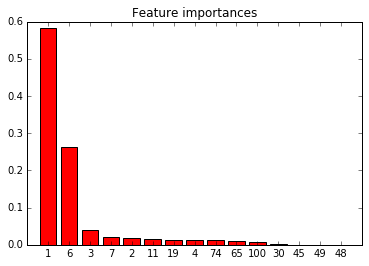

In [57]:
%matplotlib inline 
clf.fit(X,y)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


numShow = 15
for f in range(numShow):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f]+1, newcolumns[indices[f]+3], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices+1)
# plt.xlim([-1, X.shape[1]])
plt.bar(range(numShow), importances[indices][:numShow], color="r", align="center")  # Just plot top 15 features
plt.xticks(range(numShow), indices+1)
plt.xlim([-1, numShow])
plt.show()

In [58]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn import tree
from sklearn.datasets import load_iris
import pydot
import os

iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)  

dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("iris.pdf") 

# tree.export_graphviz(clf, out_file=dot_data,  
#                          feature_names=iris.feature_names,  
#                          class_names=iris.target_names,  
#                          filled=True, rounded=True,  
#                          special_characters=True)  
# graph = pydot.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())  

AttributeError: 'list' object has no attribute 'write_pdf'

Adjusting different scoring parameters: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [59]:
cross_val_score(clf, X, y, cv=10, scoring='f1') 

array([ 0.52767528,  0.52631579,  0.56071429,  0.55534709,  0.49621212,
        0.54376164,  0.571949  ,  0.49425287,  0.57462687,  0.55855856])

In [60]:
cross_val_score(clf, X, y, cv=10, scoring='f1_weighted')  ## "weighted" accounts for class imbalance

array([ 0.52972515,  0.52034004,  0.55541648,  0.55191922,  0.52392672,
        0.54234616,  0.58178294,  0.49986004,  0.56495957,  0.54073145])

In [631]:
cross_val_score(clf, X, y, cv=10, scoring='roc_auc')

array([ 0.65475187,  0.66789431,  0.64543746,  0.61736294,  0.64177527,
        0.65134534,  0.67377455,  0.6756471 ,  0.64467047,  0.65457229])

In [429]:
cross_val_score(clf, X, y, cv=10, scoring='precision')

array([ 0.60984848,  0.58122744,  0.685     ,  0.67123288,  0.57894737,
        0.57615894,  0.62871287,  0.63103448,  0.67875648,  0.6187291 ])

In [430]:
cross_val_score(clf, X, y, cv=10, scoring='recall')

array([ 0.59851301,  0.59851301,  0.50929368,  0.5464684 ,  0.6133829 ,
        0.64684015,  0.47211896,  0.6802974 ,  0.48698885,  0.69029851])

### Logistic regression

In [416]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(penalty='l2', class_weight='balanced', solver='liblinear')
cross_val_score(clf2, X, y, cv=10)   ## accuracy

array([ 0.55390335,  0.54275093,  0.57249071,  0.57249071,  0.55576208,
        0.52973978,  0.54460967,  0.60594796,  0.58364312,  0.56529851])

### Comparison between classifiers

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [418]:
names = ["3 Nearest Neighbors",  "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis"
        ]  ## "Linear SVM", "RBF SVM", "Quadratic Discriminant Analysis"
classifiers = [
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),  ## very slow (can't wait)  
#     SVC(gamma=2, C=1), ## very slow (can't wait)
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
#     LinearDiscriminantAnalysis()
    ]

In [419]:
for name, clf in zip(names, classifiers):
    score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    avgscore = score.sum()/len(score)
    print(name, avgscore)

3 Nearest Neighbors 0.523892562549
Decision Tree 0.653725924867
Random Forest 0.644916471694
AdaBoost 0.658595220442
Naive Bayes 0.593501156402


In [423]:
for name, clf in zip(names, classifiers):
    score = cross_val_score(clf, X, y, cv=10, scoring='f1')
    avgscore = score.sum()/len(score)
    print(name, avgscore)

3 Nearest Neighbors 0.51938787068
Decision Tree 0.600178354239
Random Forest 0.588415732085
AdaBoost 0.58835246045
Naive Bayes 0.406376563799


In [421]:
for name, clf in zip(names, classifiers):
    score = cross_val_score(clf, X, y, cv=10)
    avgscore = score.sum()/len(score)
    print(name, avgscore)

3 Nearest Neighbors 0.523055956278
Decision Tree 0.613618015869
Random Forest 0.612506242024
AdaBoost 0.616229956167
Naive Bayes 0.560985962381


### 	To do list   (9/12 월 - 9/23 금):
#### 	데이터 무결성 체크 
*	이유: 현재 prediction score가 너무 높게 나옴, 의심을 해 봐야 함.
*	in이 포함되지 않은 로그 모든 경우에 대해 다 제거  (기존엔 revisit_intention = 1 이상인 경우에는, 이미 방문 기록이 있기 때문에 쇼윈도만 구경하거나 한 out log의 경우 그냥 남겨 놓았음 - 다른 방식으로 이용할 수는 있을 듯)
*	직원 여부가 1번이라도 찍힌 device_id는 초기에 완전 제거
*	다수의 로그가 동시에 찍히거나,  시간이 겹치는 경우에 대해 룰을 정리하기 
    *	동시에 찍힐 경우, 더 세부적인 구역을 택하기
    
#### 초기 방문을 위주로 고려해보기
* 	여러 번 방문한 경우 단골이고 심한 경우 택배 기사일 수도.
* 	단골들은 이미 많이 오니까, 쿠폰 같은 걸 줘서 추가 방문을 유도하는 게 큰 의미가 없을 수 있다. 고로, 각 유저별 초기 1-2회 방문의 moving pattern을 위주로 고려해보자. (로그 수는 줄겠지만)

#### 특수 케이스들 고찰
* 	out-out-out-in과 같은 경우에, out을 제거할 수도 있겠지만, 실제 방문 전에 몇 번 지나다녔다는 의미를 부여할 수 있음

#### Revisit interval을 3달로 잡기
*	number of total visit (history)도 이에 따라 변함 - (참고) interval 변경은 쉽지만 계산하는 데 running time이 조금 있음

#### 방문 횟수를 포함 vs 불포함한 예측 모델 결과 분석

#### 추가로  하이 레벨 feature  만들기
* Moving patterns 관련 feature
    * A-B로 이동한 패턴이 나왔느냐, 몇번 나왔느냐 등을 feature로 생성 
    * 1단계 분석에선 이동 시간은 고려하지 않아도 됨
* 동행자와 함께 한 시간 or 동행자의 history, 동행자와 함께 있었던 시간의 비율 등 고려해보기

#### Miscellaneous	
* 이의진 교수님 Dr.M 데이터 미팅 나가기 with 하연(9/13 화요일 2시)
* 코오롱 문정점 방문 계획 (출장 신청 가능) - 양해를 구하고 매장 와이파이 로그 위치 확인과 장시간 머무르기? 
* 넓게 생각하기
    * 민수형 연구(interruptibility)와 내 연구, Dr.M 데이터셋으로 할 수 있는 연구가 다 같은 연장선상에 있고, 일치되는 예측이다.
    * 다음 미팅 때는 To-do list를 띄워놓고 하나씩 말씀드리기



### 데이터 validity check한 흔적들... (160911 이전)

In [67]:
### visit_count(매장에 정식으로 방문한 횟수)가 1이상인 moving patterns 중 6개월 내에 revisit intention이 있는 moving pattern들의 count
trajs['revisit_intention'].value_counts()

0.0    46331
1.0     3903
Name: revisit_intention, dtype: int64

In [66]:
### n 이 n+1보다 큰 경우가 있는데, n번 방문 후 찍히는 outout같은 로그들(revisit과는 상관없는 로그)들이 중간에 포함되어 있어서 그렇다는 걸 알게 됨.
print(trajs['new_visit_count'].value_counts().sort_index().head(10))

### revisit_intention = 1 인 정상적인 moving pattern 개수는 monotonically decreasing함.
print(trajs.loc[(trajs['new_visit_count']==8) & (trajs['revisit_intention'] == 1)]['traj'].count())
print(trajs.loc[(trajs['new_visit_count']==9) & (trajs['revisit_intention'] == 1)]['traj'].count())

1.0     36509
2.0      3952
3.0      1115
4.0       608
5.0       527
6.0       179
7.0       349
8.0       125
9.0       218
10.0      133
Name: new_visit_count, dtype: int64
42
39


In [86]:
trajs_full['traj'].value_counts()

out                                                                                                                                                                                                                                                                                                                          1597404
out,out                                                                                                                                                                                                                                                                                                                       198370
out,out,out                                                                                                                                                                                                                                                                                                                    34865
out,out,out,out          

In [107]:
### out, in 간격이 멀수도 있구나 (기존에 out-in순서로 있는 경우에만 revisit count를 올려 주었는데, 코드 수정해야 할듯)
# trajs_full.loc[bool(re.search('in', trajs_full['traj']))]

### traj_full중에 in이 들어간 row만 따로 df로 trajs_in이라고 만듦. - 어떤 traj들이 있다 확인
trajs_in = trajs_full.loc[trajs_full['traj'].str.contains('in')]
# trajs_in['traj'].value_counts()

In [115]:
print(trajs_full.index.size)
print(trajs_in.index.size)
print(trajs_full.index.difference(trajs_in.index).size)

1876809
19929
1856880


In [118]:
### 전체 트라젝토리 중 in이 없는 트라젝토리 (out-out-out 이외의 딴것이 있나 확인을 위해)
trajs_notin = trajs_full.loc[trajs_full.index.difference(trajs_in.index)]

In [120]:
### (out-out-out 이외의 딴것이 있긴 하지만 매우 적으므로, 그냥 가용한 트라젝토리를 in이 포함된 트라젝토리로 하기로 한다.)
trajs_notin['traj'].value_counts()

out                                                                                                                                                                                                                                                                                                                                                           1597404
out,out                                                                                                                                                                                                                                                                                                                                                        198370
out,out,out                                                                                                                                                                                                                                                                                 

### Trajectory 분석

In [30]:
trajs_combined_balanced.sort(columns='num_sp_100', ascending=False).head(3)

/Users/sundong/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,date,device_id,traj,new_visit_count,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,revisit_intention
16744_defcd753fb1a9eb2821bd20aed9de011,16744.0,defcd753fb1a9eb2821bd20aed9de011,"out,in,1f,1f-right,3f,2f,2f-inner,2f-left,2f-r...",1.0,28,12346,23.0,0.920000,9460.0,194.775963,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16890_fa9f4de287e95e4e94ab0a024a829bc8,16890.0,fa9f4de287e95e4e94ab0a024a829bc8,"out,in,1f,1f-inner,1f-right,1f-left,out,in,1f,...",1.0,21,14945,16.0,0.941176,10884.0,295.822357,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
16840_0678fe19566584cf0701b4a18b5aca54,16840.0,0678fe19566584cf0701b4a18b5aca54,"out,in,1f,1f-right,2f,2f-left,2f-inner,2f-righ...",1.0,20,12856,14.0,0.823529,8972.0,308.268828,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [82]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+')
corpus = trajs_combined_balanced['traj']   # .tolist()
corpvec = vectorizer.fit_transform(corpus)
print(corpvec.toarray())
print(vectorizer.get_feature_names())
print(vectorizer.transform(['Something completely new.']).toarray())
corpvec


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 2]
 [1 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 2 2]
 [0 0 0 ..., 0 1 2]
 [0 0 0 ..., 0 1 2]]
['1f', '1f-inner', '1f-left', '1f-right', '2f', '2f-inner', '2f-left', '2f-right', '3f', 'in', 'out']
[[0 0 0 0 0 0 0 0 0 0 0]]


<5378x11 sparse matrix of type '<class 'numpy.int64'>'
	with 23808 stored elements in Compressed Sparse Row format>

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
bigram_vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+', ngram_range=(1, 2))
analyze = bigram_vectorizer.build_analyzer()
print(analyze('Bi-grams are cool!') == (['bi-grams', 'are', 'cool', 'bi-grams are', 'are cool']))
corpvec2 = bigram_vectorizer.fit_transform(corpus)
print(corpvec2.toarray())
print(bigram_vectorizer.get_feature_names())
corpvec2

True
[[0 0 0 ..., 1 1 0]
 [1 0 0 ..., 2 1 1]
 [1 0 0 ..., 1 1 0]
 ..., 
 [0 0 0 ..., 2 2 0]
 [0 0 0 ..., 2 1 1]
 [0 0 0 ..., 2 1 1]]
['1f', '1f 1f', '1f 1f-inner', '1f 1f-left', '1f 1f-right', '1f 2f', '1f 2f-inner', '1f 2f-left', '1f 2f-right', '1f 3f', '1f in', '1f out', '1f-inner', '1f-inner 1f', '1f-inner 1f-inner', '1f-inner 1f-left', '1f-inner 1f-right', '1f-inner 2f', '1f-inner 2f-inner', '1f-inner 2f-left', '1f-inner 2f-right', '1f-inner 3f', '1f-inner in', '1f-inner out', '1f-left', '1f-left 1f', '1f-left 1f-inner', '1f-left 1f-left', '1f-left 1f-right', '1f-left 2f', '1f-left 2f-inner', '1f-left 2f-left', '1f-left 2f-right', '1f-left 3f', '1f-left in', '1f-left out', '1f-right', '1f-right 1f', '1f-right 1f-inner', '1f-right 1f-left', '1f-right 1f-right', '1f-right 2f', '1f-right 2f-inner', '1f-right 2f-left', '1f-right 2f-right', '1f-right 3f', '1f-right in', '1f-right out', '2f', '2f 1f', '2f 1f-inner', '2f 1f-left', '2f 1f-right', '2f 2f', '2f 2f-inner', '2f 2f-left', '2f 2

<5378x122 sparse matrix of type '<class 'numpy.int64'>'
	with 45208 stored elements in Compressed Sparse Row format>

In [91]:
X.shape

(5378, 14)

In [89]:
corpvec2.toarray().shape

(5378, 122)

In [104]:
X = np.concatenate((X, corpvec2.toarray()), axis=1)
newcolumns = df_learning.columns.tolist()[:-1]+bigram_vectorizer.get_feature_names()

In [36]:
df.loc[df.device_id == 'defcd753fb1a9eb2821bd20aed9de011']

,area,deny,device_id,dwell_time,key,revisit_count,revisit_period,ts,date,date_device_id,day
3407800,2f-right,NaN,defcd753fb1a9eb2821bd20aed9de011,228,786:7feaf28abb7f2b8c:2f-right,NaN,NaN,1446721636365,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407808,3f,NaN,defcd753fb1a9eb2821bd20aed9de011,266,786:7feaf28ac1960df2:3f,NaN,NaN,1446721611423,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407817,2f-left,NaN,defcd753fb1a9eb2821bd20aed9de011,285,786:7feaf28ac6529a68:2f-left,NaN,NaN,1446721592022,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407819,2f,NaN,defcd753fb1a9eb2821bd20aed9de011,306,786:7feaf28ac8812bff:2f,NaN,NaN,1446721583085,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407838,1f-right,NaN,defcd753fb1a9eb2821bd20aed9de011,409,786:7feaf28ad410b204:1f-right,NaN,NaN,1446721535732,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407839,1f,NaN,defcd753fb1a9eb2821bd20aed9de011,411,786:7feaf28ad443fb62:1f,NaN,NaN,1446721534912,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407840,in,NaN,defcd753fb1a9eb2821bd20aed9de011,411,786:7feaf28ad443fb62:in,NaN,NaN,1446721534912,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3407896,out,NaN,defcd753fb1a9eb2821bd20aed9de011,636,786:7feaf28b0751e7f8:out,NaN,NaN,1446721325793,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3411972,1f-left,NaN,defcd753fb1a9eb2821bd20aed9de011,159,786:7feaf299f846f921:1f-left,NaN,NaN,1446705658768,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
3411975,1f-right,NaN,defcd753fb1a9eb2821bd20aed9de011,337,786:7feaf299fb1c7bd3:1f-right,NaN,NaN,1446705647160,16744,16744_defcd753fb1a9eb2821bd20aed9de011,Thu
